In [9]:
# these are just basic import statements
import os
import tensorflow as tf
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
from tensorflow.python.ops.gen_array_ops import squeeze

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [10]:
# converting tensor to images
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype = np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [11]:
# download content image and style image
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [15]:
# function to load image with max 512 pixels dimension
def load_image(path_to_image):
  max_dim=512
  img = tf.io.read_file(path_to_image)
  img = tf.image.decode_image(img, channels=3)  # channels here means color channels - 3 because RGB
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32) # not really sure whats happening here, kind of reshaping it to fit?
  long_dim = max(shape)
  scale = max_dim/long_dim

  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)   # resizing?
  img = img[tf.newaxis, :]
  return img

In [16]:
# 
def display_image(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis = 0)
  plt.imshow(image)
  if title:
    plt.title(title)

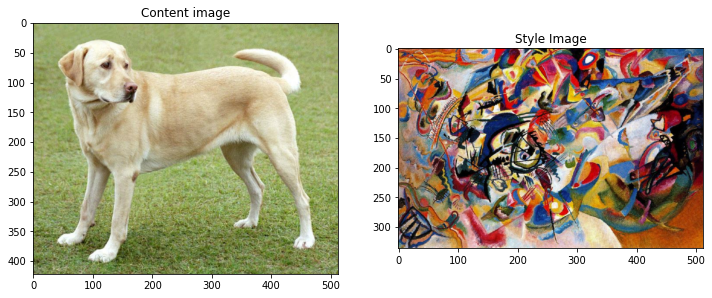

In [17]:
content_image=load_image(content_path)
style_image=load_image(style_path)

plt.subplot(1, 2, 1)
display_image(content_image, 'Content image')

plt.subplot(1, 2, 2)
display_image(style_image, 'Style Image')

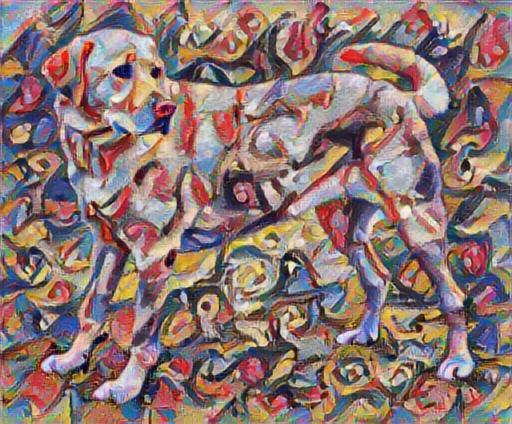

In [18]:
# trying out TensorFlow HUB model

import tensorflow_hub as hub
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# apparently this model is super quick (and partially trained?) -- transfer learning? we didnt unfreeze or retrain on anything
# took 16 seconds
# tbh the dog looks kind of perfect, there is no accomodation of "errors" made by artist? Like i can't copy a dog from a picture perfectly
# if we want to accomodate that, then we kind of WANT there to be some kind of loss/cost between the generated and content images

In [24]:
# loading a VGG19 network and verifying its able to predict our content image: dog

x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
prediction_probabilities = vgg(x)

# prediction_probabilities.shape
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
top_5 = {}

for number, class_name, prob in predicted_top_5:
  top_5[class_name] = prob

print(top_5)

{'Labrador_retriever': 0.49317285, 'golden_retriever': 0.23665173, 'kuvasz': 0.03635726, 'Chesapeake_Bay_retriever': 0.024182761, 'Greater_Swiss_Mountain_dog': 0.018646063}


In [26]:
# loading a v99 without classification head
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
for layer in vgg.layers:
  print(layer.name)

input_8
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [27]:
# choosing intermediate layers from network to represent the style and content of image 
# need to choose an inbetween layer since something too close to input would be too similar to the content

# VGG is trained to classify images so in the later layers (content) it is able to distinguish complex features
# in the earlier layers it detects things like color contrasts/edges -- good for styles?

content_layers = ['block5_conv1']

style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

n_content_layers = len(content_layers)
n_content_layers = len(style_layers)